# 粒子フィルタの実装

### 参考文献

- []()

In [1]:
using MarketData
using DataFrames
using DataStructures
using Distributions
using StatsBase
using RollingFunctions
using Pipe
using Plots
using Dates
using PyCall
talib = pyimport("talib")

ta = MarketData.yahoo("^N225")
df = DataFrame(ta)

df = df[df.timestamp .> Date(2015, 8, 1), :]
first(df, 5)

size(df)

(2158, 7)

ARCHによる確率的ボラティリティモデルとその状態方程式 <br>
$$
\begin{align}
x_t &= β_t * x_{t-1} + ν_t, \quad \nu_t \sim {\rm Normal}(0, \tau^2) \\
y_t &= e ^ {(α_t + x_t)/2} w_t, \quad w_t \sim {\rm Normal}(0,1) \\
\end{align}
$$


In [103]:
function init_particles!(particles, states, params, init; self_organized=false)
    i = 1
    for state in pairs(states)
        key, val = state
        idxs = i:i+length(val)-1
        d = init[key]
        if d isa Distribution
            particles[:,idxs] .= rand(d, n_particles)
        elseif d isa Number || d isa AbstractVector
            particles[:,idxs] .= val
        else
            @error "$typeof(val)"
        end
        i += length(val)
    end
    if self_organized
        for param in pairs(params)
            key, val = param
            d = init[key]
            idxs = i:i+length(val)-1
            if d isa Distribution
                particles[:,idxs] .= rand(d, n_particles)
            elseif d isa Number || d isa AbstractVector
                particles[:,length(state)+i] .= d
            else
                @error "typeof($v) $v"
            end
            i += length(val)
        end
    end
end

# 粒子フィルタ
function particle_filter(
    y;
    states, 
    params,
    init,
    system_noise,
    f,
    h,
    loglikelihood_func,
    n_particles=10000, 
    self_organized=false
)
    labels = OrderedSet([
        keys(states)..., 
        keys(params)...
    ])
    @assert length(labels) == sum(length(states) + length(params))
    
    n_obs_dim = size(y,2) # 
    n_state_dim = length(states)
    n_param_dim = length(params)

    n_particle_dim = self_organized ? n_state_dim + n_param_dim : n_state_dim # 粒子数
    @info "n_particle_dim=$n_particle_dim"
    particles = zeros(n_particles, n_particle_dim)  # 粒子配列
    predicted = zeros(n_particles, n_obs_dim) # 予測粒子
    weights = zeros(n_particles) # 粒子重み
    normed_weights = zero(weights) # 粒子重み(正規化)

    # 各時刻の粒子の統計量を保存する変数
    results = OrderedDict{Symbol, DataFrame}(l => DataFrame() for l in labels)
    results[:loglik] = DataFrame()

    # 粒子初期化
    init_particles!(particles, states, params, init; self_organized=self_organized)
    
    for i in axes(y,1)
        # 状態遷移
        for j in axes(particles, 2)
            j > 1 && break
            for k in axes(particles, 1)
                # τ = sqrt(exp(particles[k,4])) + 1e-9
                τ = particles[k,4] + 1e-12
                x = particles[k,1]
                β = particles[k,3]
                @assert τ >= 0 "$τ"
                v = rand(system_noise(τ))
                particles[k,1] = f(x, β, v)
            end
        end
        
        # 粒子重み計算
        for k in eachindex(weights)
            x = particles[k,1]
            α = particles[k,2]
            predicted[k] = σ = h(x, α)
            weights[k] = loglikelihood_func(y[i], σ)
        end
        push!(results[:loglik], (loglik = sum(w for w in weights if !isinf(w)),))
        # 粒子重みを正規化
        normed_weights .= exp.(weights .- maximum(weights))
        normed_weights ./= sum(normed_weights)

        # 統計量保存
        add_stats!(results, predicted, :y, 1)
        for (index, symbol) in enumerate([:x, :α, :β, :τ])
            add_stats!(results, particles, symbol, index)
        end
        
        # リサンプリング
        new_indices = rand(Categorical(normed_weights), n_particles)
        particles = particles[new_indices,:]
    end
    results
end

# 各粒子の統計量を算出する
function add_stats!(results, particles, label, index)
    if !hasproperty(results, label)
        results[label] = DataFrame()
    end
    push!(results[label], (
        median=median(particles[:,index]),
        q25=quantile(particles[:,index], 0.25),
        q75=quantile(particles[:,index], 0.75),
    ))
end

add_stats! (generic function with 1 method)

In [104]:
# 価格差をモデリングする
# TODO: 定常状態になるまでwamup期間を考慮する
df = dropmissing(df)
ts = df[:, :timestamp]
y = df[:, :AdjClose]
y_diff = diff(y)

n_particles = 10000

states = (x = 0.0,)

params = (
    α = 0.0,
    β = 0.0,
    τ = 0.0,
)

system_noise = (τ) -> Normal(0, τ)
init = (
    x = Normal(0,1), 
    α = TDist(1), 
    β = Uniform(0,1), 
    τ = truncated(TDist(1), 0, nothing),
)
f = (x, β, ν) -> β * x + ν
h = (x, α) -> exp((x + α)/2)
loglikelihood_func = (y, σ) -> loglikelihood(Normal(0, σ), y)

results = particle_filter(y_diff;
    states=states,
    params=params,
    system_noise=system_noise,
    n_particles=n_particles,
    init=init,
    f = f,
    h = h,
    loglikelihood_func = loglikelihood_func,
)

┌ Info: n_particle_dim=1
└ @ Main /Users/kizawamasakazu/repos/julia-ml/work/time_series/particle_filter/scratch/stocastic_volatirity.ipynb:57


BoundsError: BoundsError: attempt to access 10000×1 Matrix{Float64} at index [1, 4]

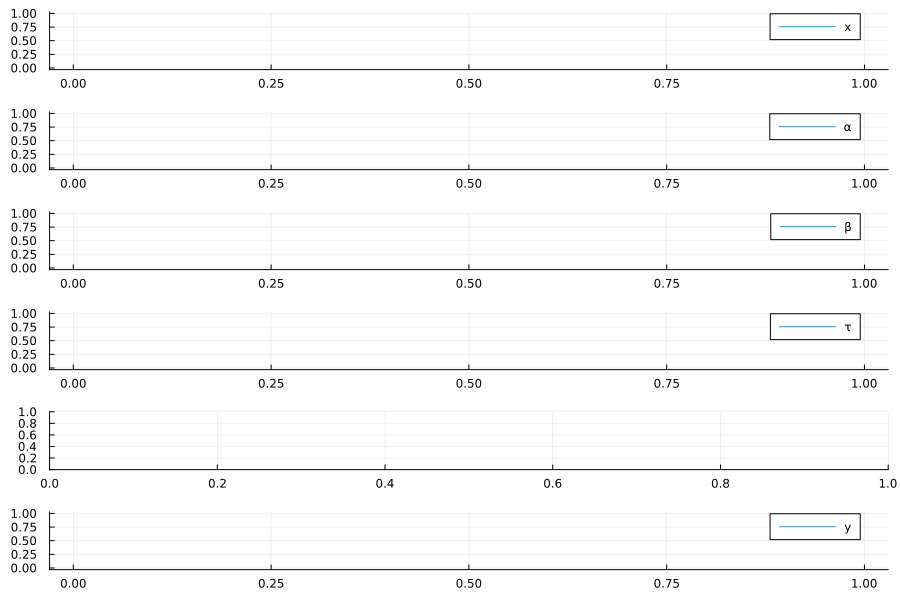

In [93]:
n = length(keys(results))
p = plot(layout=(n,1), size=(900,600))
skip = 20
for (i, key) in enumerate(keys(results))
    !hasproperty(results[key], :median) && continue
    plot!(p[i], results[key].median[skip:end], label=string(key),
        # fillrange = (results[key].q25[skip:end], results[key].q75[skip:end]),
        # fillalpha = 0.3,
    )
end
display(p)

In [32]:
function calc_loglikelihood(loglik::AbstractVector, m::Integer)
    N = length(loglik)
    return sum(loglik) - N * log(m)
end

loglik = calc_loglikelihood(results[:loglik][!,:loglik], n_particles)

-7.412834087946367e280

Row,loglik
,Float64
1,-7.41283e280
2,-9.57148e137
3,-3.43043e80
4,-1.04202e37
5,-5.82727e9
6,-1.46294e7
7,-1.61252e6
8,-3.05515e5
9,-1.18187e5
